<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения" data-toc-modified-id="Подготовка-данных-для-обучения-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных для обучения</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Примитивный-классификатор" data-toc-modified-id="Примитивный-классификатор-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Примитивный классификатор</a></span></li><li><span><a href="#Линейный-классификатор" data-toc-modified-id="Линейный-классификатор-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Линейный классификатор</a></span></li><li><span><a href="#Метод-опорных-векторов" data-toc-modified-id="Метод-опорных-векторов-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Метод опорных векторов</a></span></li><li><span><a href="#Классификатор-на-основе-стахостического-градиентного-спуска" data-toc-modified-id="Классификатор-на-основе-стахостического-градиентного-спуска-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Классификатор на основе стахостического градиентного спуска</a></span></li><li><span><a href="#СatBoost" data-toc-modified-id="СatBoost-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>СatBoost</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tqdm import notebook
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier

In [3]:
RND = 12345

### Анализ данных

In [4]:
df = pd.read_csv('toxic_comments.csv')

In [5]:
df.sample(n = 10)

,text,toxic
61708,"""\n\n Personal Attacks \n\nCalling me a racist...",0
54507,It is not the state which is important. Rathe...,0
69471,Merge discussion for Match crossbow\n An artic...,0
88093,"(talk) 20:57, Jun 23, 2005 (UTC)",0
86420,Add Article Section \n\nI believe a section sh...,0
155208,"""\n\nTheir website is all fancy flash so I can...",0
15952,"Tags\n\nThose tags are horrid. Please, someone...",0
144841,"""\n\nI demur that any of the above charges are...",0
122155,This article in the New York Times offers an a...,0
150385,I notice that his sock puppet was called,0


In [6]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df.toxic.value_counts(normalize = True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

### Подготовка данных для обучения

In [9]:
text = df['text'].values

In [10]:
%%time
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(text)):
    # Удаляем все специальные символы
    document = re.sub(r'\W', ' ', str(text[sen]))
    
    # Удаляем единичные символы
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Удаляем единычные символы из начала строки
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Заменяем несколько пробелов на один
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Удаляем 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Переводим заглавные буквы в строчные
    document = document.lower()
    
    # Лемматизация
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    documents.append(document)
    

CPU times: user 39 s, sys: 195 ms, total: 39.2 s
Wall time: 39.2 s


In [11]:
lemmas = pd.Series(documents, name='lemmas')
comments = pd.concat([df, lemmas], axis=1)

In [12]:
X = comments['lemmas']
y = comments['toxic']

In [13]:
X_train, X_sub, y_train, y_sub = train_test_split(X, y, test_size=0.4, stratify=y, random_state=RND)
X_valid, X_test,  y_valid, y_test = train_test_split(X_sub, y_sub, stratify=y_sub, test_size=0.5, random_state=RND)

In [14]:
X_train.shape, X_valid.shape, X_test.shape

((95742,), (31914,), (31915,))

In [15]:
tfidfconverter = TfidfVectorizer(max_features=6000, 
                                 min_df=5, max_df=0.7, 
                                 stop_words=stopwords.words('english'))
X_train_tf = tfidfconverter.fit_transform(X_train)
X_valid_tf = tfidfconverter.transform(X_valid)
X_test_tf = tfidfconverter.transform(X_test)

- имеется дисбаланс классов, почти 90 % это класс 0, остальное - класс 1;
- произвели подготовку к работе моделей МО: очистка данных на основе регулярных выражений, леммитизация, разделение на целевой признак и фичи для обучения, разделили данные на обучающую выборку, выборку валидации и тестовую выборку, произвели преобразование данных к TF-IDF фичам.

## Обучение

In [16]:
# Датасет для хранения результатов работы моделей
res = {
    'model_name':pd.Series(['LogReg','LinSVM','SGD','CatBoost']),
    'f1_val_nltk':pd.Series([]),
    'f1_test_nltk':pd.Series([]),
    }

results = pd.DataFrame(res)

In [17]:
# функция для поиска оптимальных гиперпараметров модели
def grid_search(model, params, features, target):
    
    search = GridSearchCV(model, params, verbose=1, cv=5, scoring='f1', n_jobs=-1)
    search.fit(features, target)
    
    print(search.best_score_)
    print(search.best_params_)

In [18]:
# функция для вывода результатов работы модели 
def model_report(fitted_model, feature, target):

    pred = fitted_model.predict(feature)
    conf_matrix = confusion_matrix(target, pred)
    
    print('f1_score = {:.3}'.format(f1_score(target, pred)))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
    plt.title('Confusion matrix')

### Примитивный классификатор

f1_score = 0.185
Лучшая стратегия DummyClassifier: constant


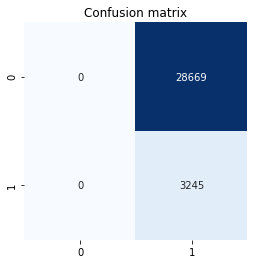

In [23]:
f1_max = 0
strat_best = 'most_frequent'

for strat in ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']:
    dummy = DummyClassifier(strategy=strat, constant=1, random_state=RND)
    dummy.fit(X_train_tf, y_train)
    f1_new = f1_score(y_valid, dummy.predict(X_valid_tf))
    if f1_max < f1_new:
        f1_max = f1_new
        strat_best = strat
        model_best = dummy
model_report(model_best, X_valid_tf, y_valid)
print('Лучшая стратегия DummyClassifier:', strat_best)

Качество работы примитивного классификатора невысокое, что и было ожидаемо. Данный результат может быть использован для сравнения с моделями МО.

### Линейный классификатор

In [20]:
lr = LogisticRegression(random_state=RND)

lr_params = dict(C = [0.1,1,10,100], 
                 tol = [1e-03, 1e-04, 1e-05])

In [21]:
grid_search(lr, lr_params, X_train_tf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.7589963408847324
{'C': 10, 'tol': 0.001}


In [22]:
lr_final = LogisticRegression(C=10, tol=0.0001)

lr_final.fit(X_train_tf, y_train);

In [23]:
f1_score(y_train, lr_final.predict(X_train_tf))

0.827021494370522

f1_score = 0.759


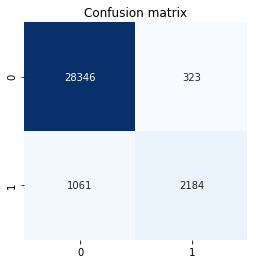

In [24]:
model_report(lr_final, X_valid_tf, y_valid)

Таким образом, имеем:
- 321 ложноположительных значений;
- 1063 ложноотрицательных значений.

__Видно, что значительно больше ошибок по отнесению токсичных комментариев к нетоксичным, но критерий f1-score был выбран по условию задачи и именно его мы пытаемся максимизировать. В дальнейшем матрицу соответствия комментировать не будем, так как результаты примерно везде одинаковые.__

In [25]:
results.loc[0, 'f1_val_nltk'] = 0.759

Линейный классификатор (логистическая регрессия) показал качество на выборке валидации не хуже требуемого значения 0.75.

### Метод опорных векторов

In [26]:
svm = LinearSVC(random_state = RND)

svm_params = dict(C=[0.1,1,10,100],
                  max_iter=[1000,2000])

In [27]:
#grid_search(svm, svm_params, X_train_tf, y_train)

In [28]:
svm_final = LinearSVC(C=1, max_iter=1000, random_state=RND)

svm_final.fit(X_train_tf, y_train);

In [29]:
f1_score(y_train, svm_final.predict(X_train_tf))

0.8234284733741349

f1_score = 0.76


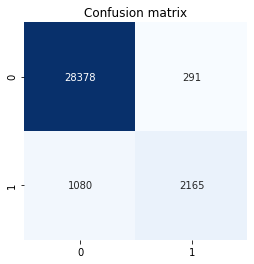

In [30]:
model_report(svm_final, X_valid_tf, y_valid)

In [31]:
results.loc[1, 'f1_val_nltk'] = 0.76

### Классификатор на основе стахостического градиентного спуска

In [32]:
sgd = SGDClassifier(random_state=RND)

sgd_params = dict(alpha=[1e-04, 1e-05, 1e-06],
                  penalty=['l1','l2'])

In [33]:
grid_search(sgd, sgd_params, X_train_tf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.7670412477499791
{'alpha': 1e-05, 'penalty': 'l1'}


In [34]:
sgd_final = SGDClassifier(alpha=1e-05, penalty='l1', random_state=RND)

sgd_final.fit(X_train_tf, y_train);

In [35]:
f1_score(y_train, sgd_final.predict(X_train_tf))

0.7927162720344406

f1_score = 0.763


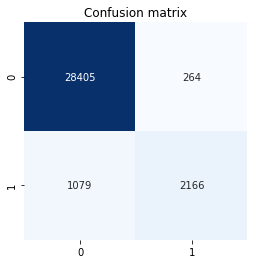

In [36]:
model_report(sgd_final, X_valid_tf, y_valid)

In [37]:
results.loc[2, 'f1_val_nltk'] = 0.763

### СatBoost

In [38]:
cbc = CatBoostClassifier(
                    loss_function='Logloss',
                    iterations=300,
                    learning_rate=0.9,
                    depth=4,
                    verbose=10,
                    random_state=RND)

In [39]:
cbc.fit(X_train_tf, y_train)

0:	learn: 0.2717758	total: 909ms	remaining: 4m 31s
10:	learn: 0.1776746	total: 8.11s	remaining: 3m 33s
20:	learn: 0.1563104	total: 15.1s	remaining: 3m 21s
30:	learn: 0.1445951	total: 22.2s	remaining: 3m 12s
40:	learn: 0.1377154	total: 28.9s	remaining: 3m 2s
50:	learn: 0.1328592	total: 35.5s	remaining: 2m 53s
60:	learn: 0.1283320	total: 42.3s	remaining: 2m 45s
70:	learn: 0.1247865	total: 49.2s	remaining: 2m 38s
80:	learn: 0.1220921	total: 56s	remaining: 2m 31s
90:	learn: 0.1194823	total: 1m 2s	remaining: 2m 23s
100:	learn: 0.1166171	total: 1m 9s	remaining: 2m 16s
110:	learn: 0.1144232	total: 1m 16s	remaining: 2m 10s
120:	learn: 0.1124988	total: 1m 23s	remaining: 2m 3s
130:	learn: 0.1105302	total: 1m 30s	remaining: 1m 56s
140:	learn: 0.1086097	total: 1m 37s	remaining: 1m 49s
150:	learn: 0.1074139	total: 1m 43s	remaining: 1m 42s
160:	learn: 0.1059247	total: 1m 50s	remaining: 1m 35s
170:	learn: 0.1046039	total: 1m 56s	remaining: 1m 28s
180:	learn: 0.1036055	total: 2m 3s	remaining: 1m 20s
1

In [40]:
pred = cbc.predict(X_train_tf)

f1_score(y_train, pred)

0.8302479524290363

f1_score = 0.745


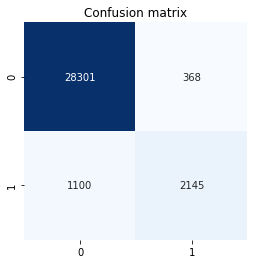

In [41]:
model_report(cbc, X_valid_tf, y_valid)

In [42]:
results.loc[3, 'f1_val_nltk'] = 0.745

In [43]:
results

,model_name,f1_val_nltk,f1_test_nltk
0,LogReg,0.759,NaN
1,LinSVM,0.760,NaN
2,SGD,0.763,NaN
3,CatBoost,0.745,NaN


- Произвели обучение моделей МО;
- Произвели подбор отдельных гиперпараметров моделей МО;
- Рассмотренные модели показали на выборке валидации сопоставимые результаты и выше требуемого значения 0.75, за исключением CAtBoost (f1 =  0.739)

## Тестирование моделей

f1_score = 0.763


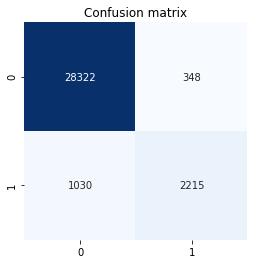

In [44]:
model_report(lr_final, X_test_tf, y_test)

f1_score = 0.766


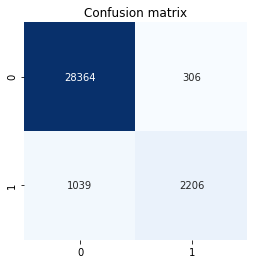

In [45]:
model_report(svm_final, X_test_tf, y_test)

f1_score = 0.763


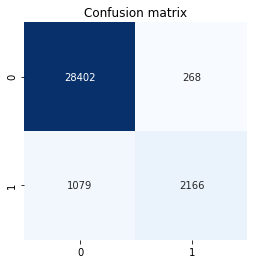

In [46]:
model_report(sgd_final, X_test_tf, y_test)

f1_score = 0.75


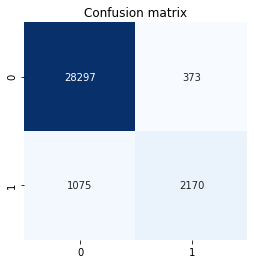

In [47]:
model_report(cbc, X_test_tf, y_test)

Анализ матриц соответствия показывает, что модели МО как и на выборке валидации допускают много значительно больше ошибок второго рода (fn). Но требований по минимизации ошибок второго рода не было поставлено. Хотя исходя из здравого смысла имеем, что около трети токсичных комментариев не будет отправлено на модерацию, что кажется неудовлетворительным результатом. Поэтому для данной задачи мог быть применен другой критерий либо f-scope c коэффициентом бетта, который позволил бы изменить соотношение ошибок первого и второго рода.

In [48]:
results.loc[0, 'f1_test_nltk'] = 0.762
results.loc[1, 'f1_test_nltk'] = 0.766
results.loc[2, 'f1_test_nltk'] = 0.763
results.loc[3, 'f1_test_nltk'] = 0.75

In [49]:
results.sort_values('f1_test_nltk', ascending = False)

,model_name,f1_val_nltk,f1_test_nltk
1,LinSVM,0.760,0.766
2,SGD,0.763,0.763
0,LogReg,0.759,0.762
3,CatBoost,0.745,0.750


Из анализа результатов работы моделей можно сделать следующие выводы:
- логистическая регрессия, метод опорных векторов, стохастический градиентный спуск показали сопоставимые результаты на тестовой выборке, примерно аналогичная картина была и выборке валидации;
- хуже других показал себя CatBoost как на выборке валидации, так и на тестовой выборке;
- выше требуемого порога показали себя логистическая регрессия, метод опорных векторов, стохастический градиентный спуск;
- выбор конкретной модели МО может быть уточнен на этапе опытной эксплуатации либо если заказчик уточнит дополнительные требования (быстройдействие, скорость обучения, аппаратные требования...)
- все рассмотренные модели МО показали даже лучшие результаты на тестовой выборке, что говорит о том, что не было допущено переобучение моделей.

## Выводы

- Анализ исходных данных показал, что имеется дисбаланс классов, почти 90 % это класс 0, остальное - класс 1;
- Качество работы примитивного классификатора невысокое, что и было ожидаемо f1-scope =  0.18. Данный результат может быть использован для сравнения с моделями МО.
- Анализ матрицы соответствия для логистической регрессии показал :
    - 321 ложноположительных значений;
    - 1063 ложноотрицательных значений.
- Видно, что значительно больше ошибок по отнесению токсичных комментариев к нетоксичным, но критерий f1-score был выбран по условию задачи и именно его мы пытаемся максимизировать. В дальнейшем матрицу соответствия комментировать не будем, так как результаты примерно везде одинаковые.__
- Рассмотренные модели показали на выборке валидации сопоставимые результаты и выше требуемого значения 0.75, за исключением CAtBoost (f1 =  0.739)
- Анализ матриц соответствия показывает, что модели МО как и на выборке валидации допускают много значительно больше ошибок второго рода (fn). Но требований по минимизации ошибок второго рода не было поставлено. Хотя исходя из здравого смысла имеем, что около трети токсичных комментариев не будет отправлено на модерацию, что кажется неудовлетворительным результатом. Поэтому для данной задачи мог быть применен другой критерий либо f-scope c коэффициентом бетта, который позволил бы изменить соотношение ошибок первого и второго рода.

- Из анализа результатов работы моделей можно сделать следующие выводы:
    - логистическая регрессия, метод опорных векторов, стохастический градиентный спуск показали сопоставимые результаты на тестовой выборке, примерно аналогичная картина была и выборке валидации;
    - хуже других показал себя CatBoost как на выборке валидации, так и на тестовой выборке;
    - выше требуемого порога показали себя логистическая регрессия, метод опорных векторов, стохастический градиентный спуск;
    - выбор конкретной модели МО может быть уточнен на этапе опытной эксплуатации либо если заказчик уточнит дополнительные требования (быстройдействие, скорость обучения, аппаратные требования...)
    - все рассмотренные модели МО показали даже лучшие результаты на тестовой выборке, что говорит о том, что не было допущено переобучение моделей;
    - все рассмотренные модели МО показали значетельно лучшие результаты чем примитивный классификатор, что говорит о достижения поставленных целей. 
